In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [30]:
torch.manual_seed(0)

## Genrate dataset

In [31]:
data, labels = make_blobs(n_samples = 1000,centers = 4,n_features = 2,random_state = 0)

In [32]:
X_train,X_val,Y_train,Y_val = train_test_split(data,labels,stratify=labels,random_state=0)

In [33]:
X_train,X_val,Y_train,Y_val = map(torch.tensor,(X_train,X_val,Y_train,Y_val))

In [34]:
a = torch.rand(2,4)
print(a)
print(a.exp())
print(a.exp().sum(0)) # Sum by columns
print(a.exp().sum(-1)) # Sum by rows 
print(a.exp().sum(1)) # Same as sum(-1)

print(a.exp().sum(-1).shape)
print(a.exp().sum(-1).unsqueeze(-1))
print(a.exp().sum(-1).unsqueeze(-1).shape)
print(a.exp()/a.exp().sum(-1).unsqueeze(-1))

tensor([[0.4963, 0.7682, 0.0885, 0.1320],
        [0.3074, 0.6341, 0.4901, 0.8964]])
tensor([[1.6426, 2.1559, 1.0925, 1.1411],
        [1.3599, 1.8853, 1.6325, 2.4509]])
tensor([3.0025, 4.0412, 2.7250, 3.5920])
tensor([6.0321, 7.3285])
tensor([6.0321, 7.3285])
torch.Size([2])
tensor([[6.0321],
        [7.3285]])
torch.Size([2, 1])
tensor([[0.2723, 0.3574, 0.1811, 0.1892],
        [0.1856, 0.2573, 0.2228, 0.3344]])


In [35]:
def model(x):
    a1 = torch.matmul(x,weights1) + bias1 # (N,2) * (2,2) -> (N,2)
    h1 = a1.sigmoid() # (N,2)
    a2 = torch.matmul(h1,weights2) + bias2 # (N,2) * (2,4) -> (N,4)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [36]:
y_hat = torch.tensor([[0.1,0.2,0.3,0.4],[0.8,0.1,0.05,0.05]])
y = torch.tensor([2,0])

print(y_hat[range(y_hat.shape[0]),y])
print(y_hat[range(y_hat.shape[0]),y].log())
print(-y_hat[range(y_hat.shape[0]),y].log().mean())

## accuracy
print(torch.argmax(y_hat,dim=1))
print((torch.argmax(y_hat,dim=1) == y).float().mean())

tensor([0.3000, 0.8000])
tensor([-1.2040, -0.2231])
tensor(0.7136)
tensor([3, 0])
tensor(0.5000)


In [37]:
def loss_fn(y_hat,y):
    return -(y_hat[range(y.shape[0]),y].log()).mean()

In [38]:
def accuracy(pred,y):
    y_hat = torch.argmax(pred,dim=1)
    return (y_hat == y).float().mean()

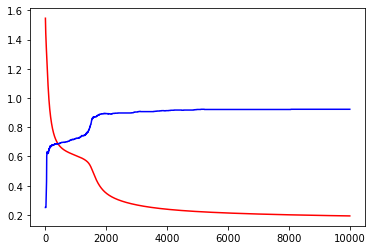

Wall time: 13.4 s


In [48]:
%%time
torch.manual_seed(0)
weights1 = torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2,requires_grad=True)

weights2 = torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4,requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    Y_hat = model(X_train)
    loss = loss_fn(Y_hat,Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(Y_hat,Y_train))
    
    with torch.no_grad():
        weights1 -= weights1.grad*learning_rate
        bias1 -= bias1.grad*learning_rate
        
        weights2 -= weights2.grad*learning_rate
        bias2 -= bias2.grad*learning_rate
        
        weights1.grad.zero_()
        bias1.grad.zero_()
        
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr,'r-')
plt.plot(acc_arr,'b-')
plt.show()

### Using NN.Functional

In [49]:
import torch.nn.functional as F

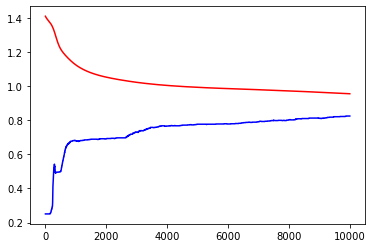

Wall time: 13.5 s


In [50]:
%%time
torch.manual_seed(0)
weights1 = torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2,requires_grad=True)

weights2 = torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4,requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    Y_hat = model(X_train)
    loss = F.cross_entropy(Y_hat,Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(Y_hat,Y_train))
    
    with torch.no_grad():
        weights1 -= weights1.grad*learning_rate
        bias1 -= bias1.grad*learning_rate
        
        weights2 -= weights2.grad*learning_rate
        bias2 -= bias2.grad*learning_rate
        
        weights1.grad.zero_()
        bias1.grad.zero_()
        
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr,'r-')
plt.plot(acc_arr,'b-')
plt.show()

### Using NN.Parameter

In [51]:
import torch.nn as nn

In [58]:
class FirstNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.weights1 = nn.Parameter(torch.randn(2,2)/math.sqrt(2))
        self.bias1 = nn.Parameter(torch.zeros(2))
        self.weights2 = nn.Parameter(torch.randn(2,4)/math.sqrt(2))
        self.bias2 = nn.Parameter(torch.zeros(4))
    
    def forward(self,X):
        a1 = torch.matmul(X,self.weights1) + self.bias1
        h1 = a1.sigmoid()
        a2 = torch.matmul(X,self.weights2) + self.bias2
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [66]:
X_train = X_train.float()
Y_train = Y_train.long()

In [84]:
def fit(epochs = 1000,learning_rate=1):
    loss_arr = []
    acc_arr = []
    
    
    
    for epoch in range(epochs):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat ,Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat,Y_train))
        
        loss.backward()
        with torch.no_grad():
            for param in fn.parameters():
                param -= learning_rate * param.grad
            fn.zero_grad()
    
    plt.plot(loss_arr,'r-')
    plt.plot(acc_arr,'b-')
    plt.show()

In [85]:
fn = FirstNetwork()
fit()

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

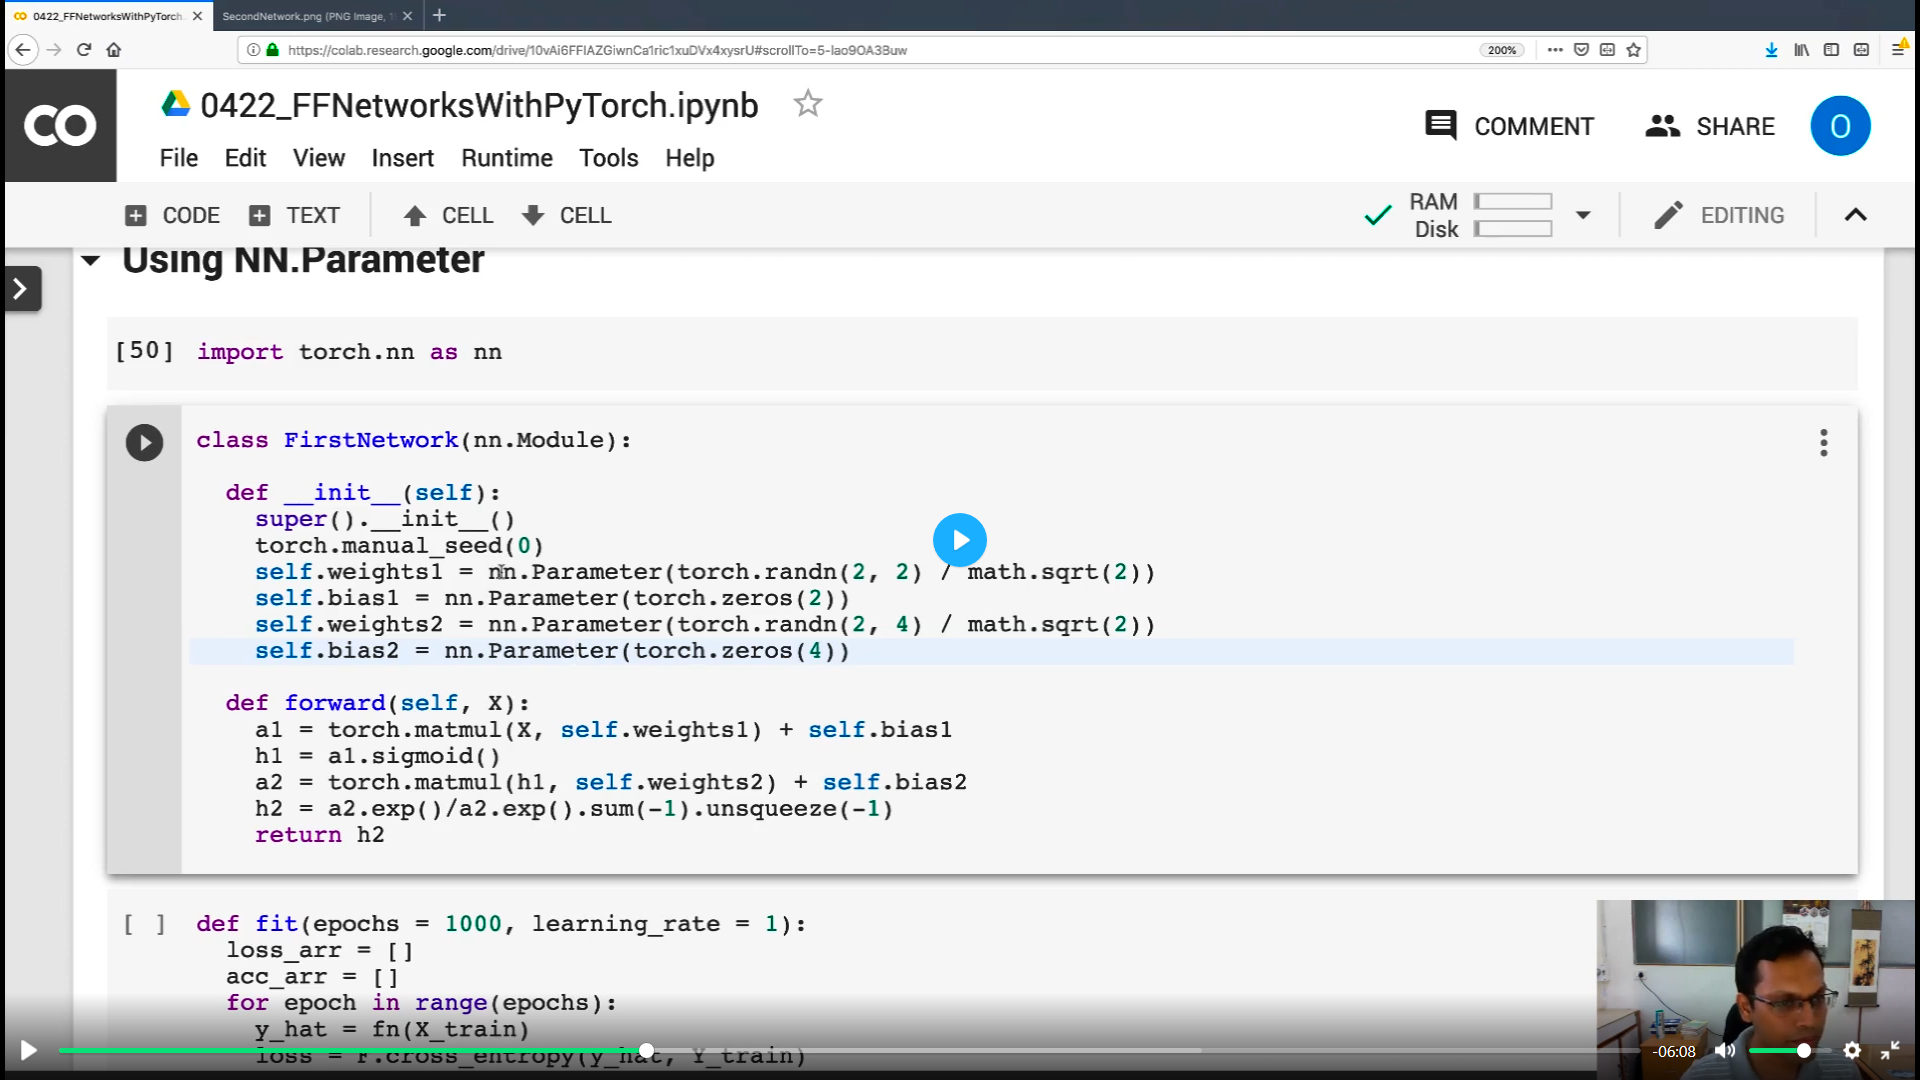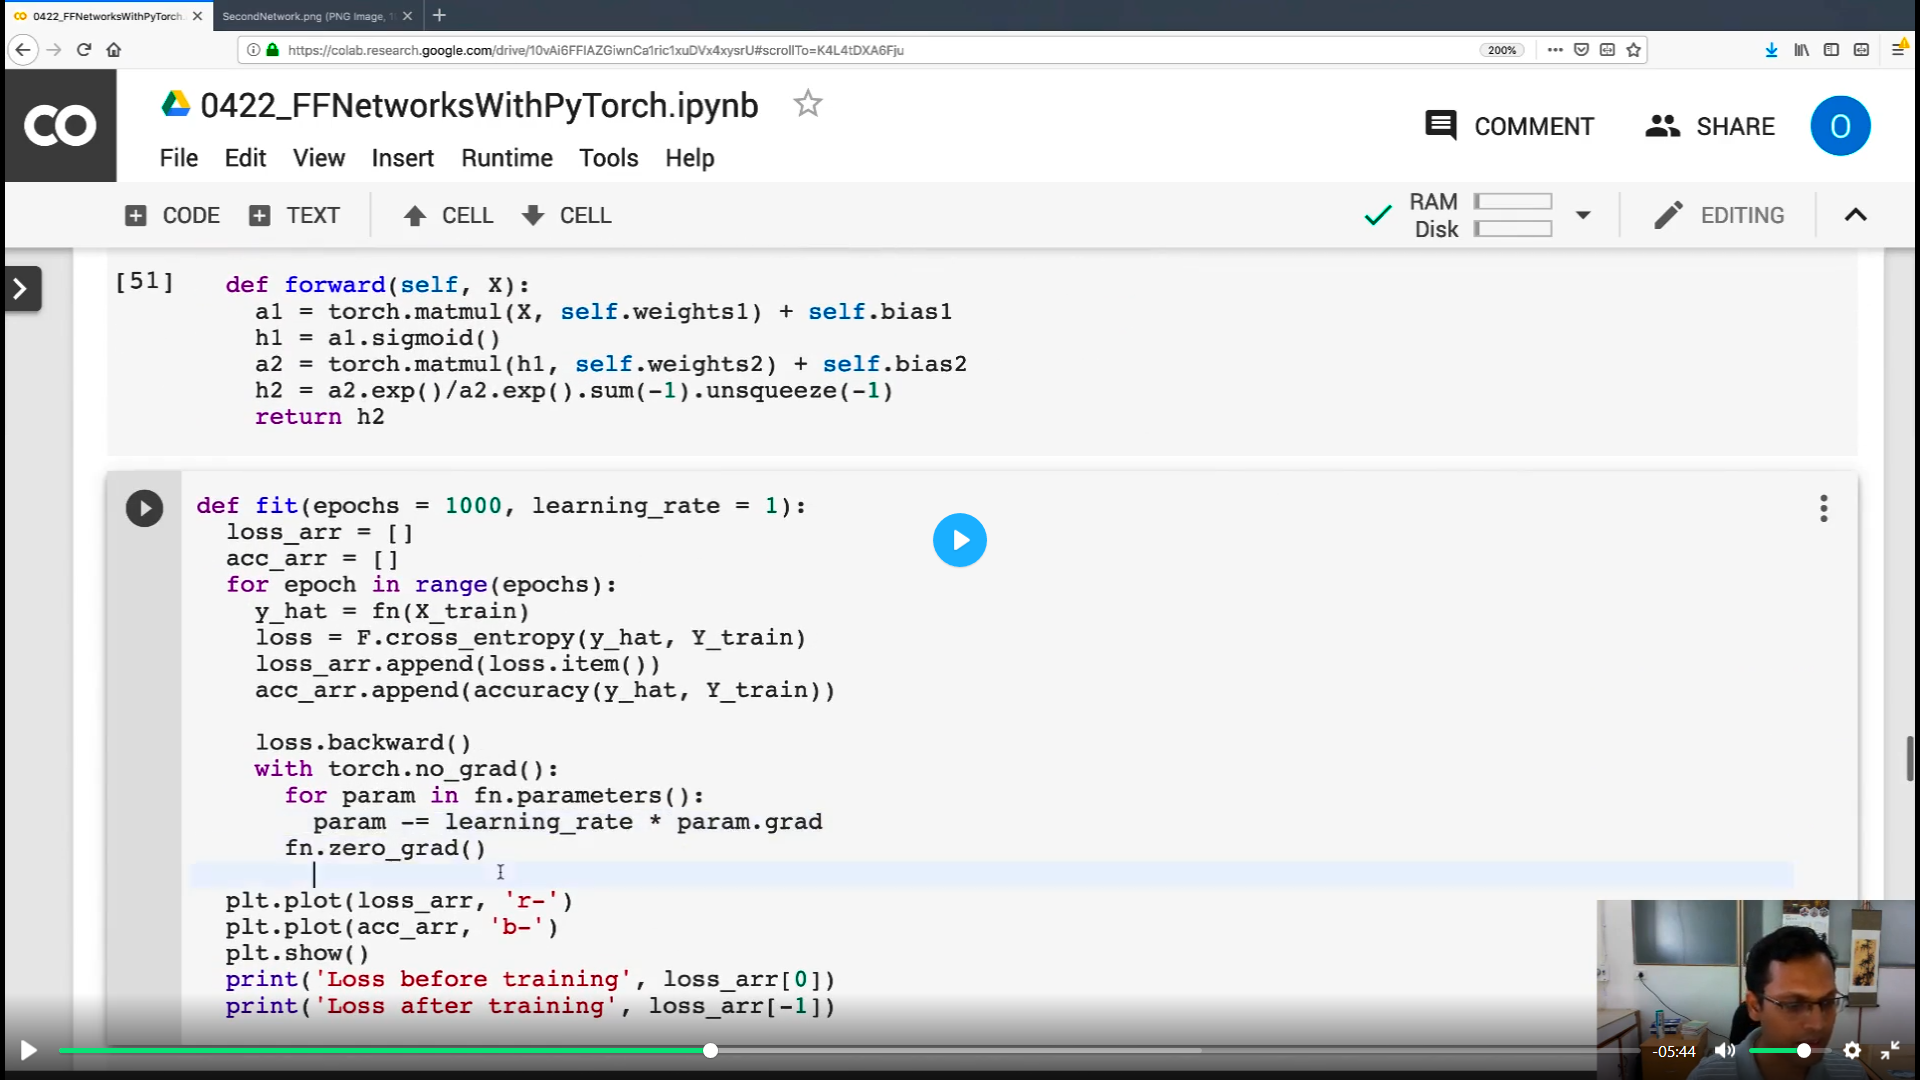

### Using nn.Linear and Optim

In [86]:
class FirstNetwork_v1(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2,2)
        self.lin2 = nn.Linear(2,4)
        
    def forward(self,X):
        a1 = self.lin1(X)
        h1 = a1.sigmoid()
        a2 = self.lin2(h1)
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

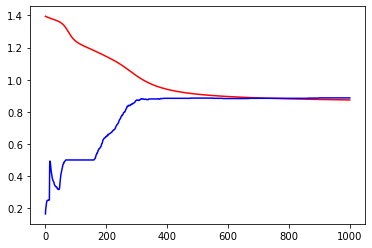

In [87]:
fn = FirstNetwork_v1()
fit()

In [88]:
from torch import optim

In [89]:
def fit_v1(epochs = 1000,learning_rate=1):
    loss_arr = []
    acc_arr = []
    
    opt = optim.SGD(fn.parameters(),lr = learning_rate)
    
    for epoch in range(epochs):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat,Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat,Y_train))
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    plt.plot(loss_arr,'r-')
    plt.plot(acc_arr,'b-')
    plt.show()

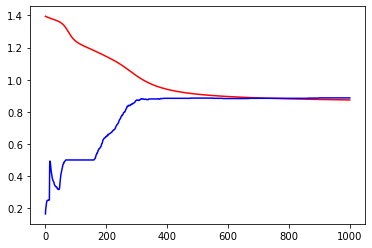

In [90]:
fn = FirstNetwork_v1()
fit_v1()

### Using NN.sequential

In [94]:
class FirstNetwork_v2(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid(),
            nn.Linear(2,4),
            nn.Softmax()
        )
    def forward(self,X):
        return self.net(X)

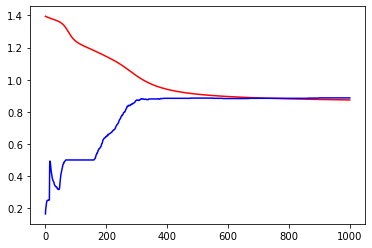

In [96]:
fn = FirstNetwork_v2()
fit_v1()

In [101]:
def fit_v2(x,y,model,opt,loss_fn,epochs=1000):
    
    for epoch in range(epochs):
        loss = loss_fn(model(x),y)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item()

In [104]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(),lr = 1)
fit_v2(X_train,Y_train,fn,opt,loss_fn)

0.8738409876823425

### Running it on GPU's

In [106]:
import time

In [110]:
device = torch.device('cpu')

X_train = X_train.to(device)
Y_train = Y_train.to(device)

fn = FirstNetwork_v2()
fn.to(device)

loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(),lr = 1)

tic = time.time()
print('Final loss ',fit_v2(X_train,Y_train,fn,opt,loss_fn))
toc = time.time()
print('Time Taken',toc - tic)

Final loss  0.8738409876823425
Time Taken 1.304762840270996


In [109]:
device = torch.device('cuda')

X_train = X_train.to(device)
Y_train = Y_train.to(device)

fn = FirstNetwork_v2()
fn.to(device)

loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(),lr = 1)

tic = time.time()
print('Final loss ',fit_v2(X_train,Y_train,fn,opt,loss_fn))
toc = time.time()
print('Time Taken',toc - tic)

Final loss  0.8738411664962769
Time Taken 1.9382655620574951
